# Soiling model demo and cleaning schedule assessment
The below code shows how to use the soiling model for a given solar field and assess the impact of a desired cleaning schedule.

In [1]:
import soiling_model as sm
import matplotlib.pyplot as plt
import numpy as np
import time

file_params = "data/parameters.xlsx"
file_weather = 'data/woomera_data.xlsx'
file_SF = 'data/SF_woomera_SolarPILOT.csv'             # solar field of 48 sectors located in Woomera
climate_file = 'data/woomera_location_modified.epw'    # only used for optical efficiency computation

n_az,n_rad = (8,6)   # number of azimuth and radial sectorization of the solar field
n_trucks = 4         # number of trucks
n_cleans = 10        # number of cleanings in time interval

# Instantiate Model
Location and solar field parameters are imported and processed to set the required inputs to the subsequent sections of the model.

`dust_type` has to be chosen according to the dust measurements, it can be either "PMX", or "TSP"


Importing constants
Importing dust
Importing full solar field and sectorizing with 6 angular and 8 radial sectors
Importing site data (weather,time). Using dust_type = PM10, test_length = 8760 hours
Length of simulation for file data/woomera_data.xlsx: 365.0 days
No rain intensity data to import.


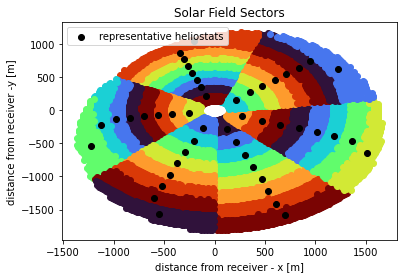

In [2]:
imodel = sm.field_model(file_params,file_SF,num_sectors=(n_az,n_rad))
sim_data = sm.simulation_inputs(file_weather,dust_type="PM10")
plant = sm.plant()
plant.import_plant(file_params)
imodel.helios.sector_plot()

The model proceeds to compute the relevant sun angles (azimuth and zenith) that are required to then evaluate the movement of the heliostats depending on plant design and time of the day.

In [3]:
imodel.sun_angles(sim_data)
imodel.helios_angles(plant)

Calculating sun apparent movement and angles for 1 simulations
Calculating heliostat movement and angles for 1 simulations
Second surface model


The actual soiling model is implemented in the following steps. 
* The amount of dust falling towards the mirrors is calculated in *imodel.deposition_flux*
* The balance between adhesive and removal forces acting on the deposited particles is assessed in *imodel.adhesion_removal*. 
* Since the heliostats are assumed to be stowed almost vertically at night, all particles that would fall on those conditions, are considered to be instantaneously removed (in practical terms, those particles never deposit on the surface).

For further information, please refer to [1] from the README.md file.

Once the amount of dust particles adhering on the surface of the heliostats has been computed, *imodel.calculate_delta_soilied_area* computes the area of the heliostats that is affected by the adhering dust particles.

In [4]:
imodel.deposition_flux(sim_data)
imodel.adhesion_removal()
imodel.calculate_delta_soiled_area(sim_data)

No value for hrz0 supplied. Using value in self.hrz0 = 50.0.
Calculating deposition velocity for each of the 1 simulations
Calculating adhesion/removal balance
  Using common stow_tilt. Assumes all heliostats are stored at helios.stow_tilt at night.
Calculating soil deposited in a timestep [m^2/m^2]


The cleaning schedule specified by $n_{trucks}$ and $n_{cleans}$ is subsequently applied. This follows the *Heuristic Approach* described in [2] from README.md. Eventually, the reflectance losses are computed.

In [5]:
cleans = sm.simple_annual_cleaning_schedule(imodel.helios.tilt[0].shape[0],n_trucks,n_cleans,dt=sim_data.dt[0]/3600.00)
cleans = imodel.reflectance_loss(sim_data,{0:cleans})

Calculating reflectance losses with cleaning for 1 simulations


The optical efficiency is computed for every sector (as the average of each heliostat belonging to the sector) in the field using a look-up table with `n_az` solar azimuth angles and `n_el` solar elevation angles. It eventually computes the average for the whole solar field.

In [6]:
imodel.optical_efficiency(plant,sim_data,climate_file,verbose=True,n_az=10,n_el=10)
field_average_clean_optical_efficiency = np.mean(imodel.helios.optical_efficiency[0]*imodel.helios.nominal_reflectance,axis=0)

Getting efficiencies for az=0.000, el=10.000
Power absorbed by receiver at DNI=1000 W/m2: 4.10e+05 kW
Getting efficiencies for az=0.000, el=18.889
Power absorbed by receiver at DNI=1000 W/m2: 5.63e+05 kW
Getting efficiencies for az=0.000, el=27.778
Power absorbed by receiver at DNI=1000 W/m2: 6.26e+05 kW
Getting efficiencies for az=0.000, el=36.667
Power absorbed by receiver at DNI=1000 W/m2: 6.61e+05 kW
Getting efficiencies for az=0.000, el=45.556
Power absorbed by receiver at DNI=1000 W/m2: 6.86e+05 kW
Getting efficiencies for az=0.000, el=54.444
Power absorbed by receiver at DNI=1000 W/m2: 7.04e+05 kW
Getting efficiencies for az=0.000, el=63.333
Power absorbed by receiver at DNI=1000 W/m2: 7.17e+05 kW
Getting efficiencies for az=0.000, el=72.222
Power absorbed by receiver at DNI=1000 W/m2: 7.23e+05 kW
Getting efficiencies for az=0.000, el=81.111
Power absorbed by receiver at DNI=1000 W/m2: 7.25e+05 kW
Getting efficiencies for az=0.000, el=90.000
Power absorbed by receiver at DNI=100

The below computes the soiling factor for each sector, and a resulting optical efficiency for each sector in soiled conditions. An average value for the whole field is also computed.

In [7]:
soiling_factor = imodel.helios.soiling_factor[0] # zero for the first "run"
field_average_soiling_factor = np.mean(soiling_factor,axis=0)

soiled_optical_efficiency = imodel.helios.optical_efficiency[0]*soiling_factor*imodel.helios.nominal_reflectance
field_average_soiled_optical_efficiency = np.mean(soiled_optical_efficiency,axis=0)

The next section allows to plot the results of the model, including the average soiling factor, the soiling factor for a selected sector, and the optical efficiency of the solar field both in clean and soiled state.

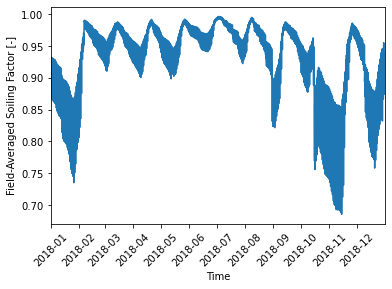

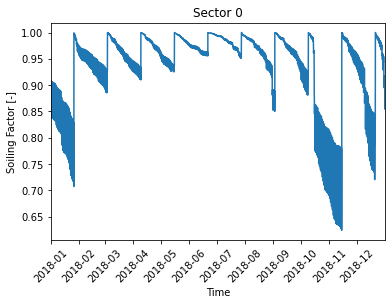

In [8]:
t = sim_data.time[0]
sec_plot = 0 # choose sector for plot

# examine field soiling - field average
fig, ax = plt.subplots();
ax.plot_date(t,field_average_soiling_factor,"-");
ax.set_xlim(t[0],t[-1]);
ax.set_xlabel("Time");
ax.set_ylabel("Field-Averaged Soiling Factor [-]");
plt.xticks(rotation=45);

# examine sector soiling 
fig, ax = plt.subplots();
ax.plot_date(t,soiling_factor[sec_plot],"-");
ax.set_xlim(t[0],t[-1]);
ax.set_xlabel("Time");
ax.set_ylabel("Soiling Factor [-]");
ax.set_title("Sector {0:d}".format(sec_plot))
plt.xticks(rotation=45);

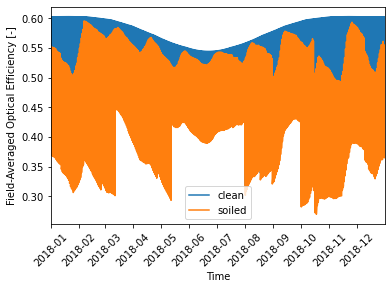

In [9]:
# examine optical efficiency - field average
fig, ax = plt.subplots();
ax.plot_date(t[imodel.sun.elevation[0]>10],field_average_clean_optical_efficiency[imodel.sun.elevation[0]>10],"-",label='clean')
ax.plot_date(t[imodel.sun.elevation[0]>10],field_average_soiled_optical_efficiency[imodel.sun.elevation[0]>10],"-",label='soiled')
ax.set_xlim(t[0],t[-1]);
ax.set_xlabel("Time");
ax.set_ylabel("Field-Averaged Optical Efficiency [-]");
plt.legend();
plt.xticks(rotation=45);


The next plot allows to assess the tilt angle of heliostats, chosing the time frame in hours between `h_start` and `h_end`

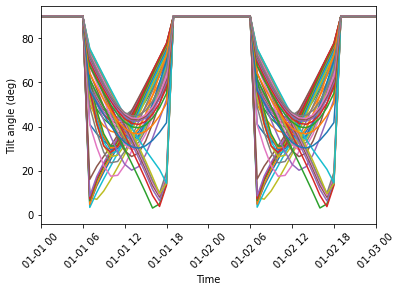

In [10]:
# examine tilts
h_start = 0
h_end = 48


Nhelios = imodel.helios.x.shape[0]
tilt = imodel.helios.tilt[0]
fig, ax = plt.subplots()
for h in range(Nhelios):
    ax.plot_date(t,tilt[h,:],"-")

ax.set_xlim(t[h_start],t[h_end])
ax.set_xlabel("Time")
ax.set_ylabel("Tilt angle (deg)")
plt.xticks(rotation=45);